In [1]:
####################Load necessary libraries####################
#%pylab inline

import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

from scipy import stats
from scipy.stats import wilcoxon

#Add personal functions to python path
sys.path.append('/neurospin/meg/meg_tmp/WMP_Darinka_2015/Final_Python')

from jr.plot import base, gat_plot, pretty_gat, pretty_decod, pretty_slices
from jr.stats import gat_stats, parallel_stats

%matplotlib inline

In [2]:
def _my_wilcoxon(X):
    out = wilcoxon(X)
    return out[1]

In [3]:
####################Define important variables####################
#Paths
data_path = '/neurospin/meg/meg_tmp/WMP_Darinka_2015/Final_Decoding/IndividualResults/Rev2_DecLoc'
indResult_path = '/neurospin/meg/meg_tmp/WMP_Darinka_2015/Final_Decoding/IndividualResults/Rev2_DecLoc/Figures'
groupResult_path = '/neurospin/meg/meg_tmp/WMP_Darinka_2015/Final_Decoding/GroupResults/Rev2_DecLoc'

#List of parameters
ListSubject = ['ab140235', 'ad120287', 'ar140056', 'cc140058', 'eg140204', 
     'el130086', 'lm130479', 'ma130185', 'ro130031', 'sa130042', 'sb120316', 
     'th130177', 'ws140212']
ListCondition = [['AllVis_Train_WM', 'Seen_Test_WMx']]

chance = 0 #chance-level

ttp = [-0.2] #starting time point
toi = [[0.3, 0.6], [0.8, 2.532]] #training time points over which to average

In [4]:
####################Initialize results####################
all_scores = []
all_diagonals = []

In [6]:
####################Load data####################
for c, cond in enumerate(ListCondition):
    for s, subject in enumerate(ListSubject):
        
        fname = data_path + '/5Fold_TestSubscore' + subject + '_' + cond[0] + '_' + cond[1] + '-score.npy'
        score = np.load(fname)
        #score = score[:, 67:751]
        all_scores.append(score)
        
        fname = data_path + '/5Fold_TestSubscore' + subject + '_' + cond[0] + '_' + cond[1] + '-diagonal.npy'
        diagonal = np.load(fname)
        all_diagonals.append(diagonal)
    
        fname = data_path + '/5Fold_TestSubscore' + subject + '_' + cond[0] + '_' + cond[1] + '-time.npy'
        time = np.load(fname)
    
all_scores = np.array(all_scores) #shape: subjects*n_cond, training_times, testing_times
all_diagonals = np.array(all_diagonals)  

In [7]:
####################Reshape data####################
all_scores = np.reshape(all_scores, (len(ListCondition), len(ListSubject), score.shape[0], score.shape[1])) #n_cond, n_subj, training_times, testing_times
all_diagonals = np.reshape(all_diagonals, (len(ListCondition), len(ListSubject), diagonal.shape[0]))


In [8]:
np.shape(all_scores)

(1, 13, 751, 751)

In [9]:
####################Select subset of time window###################
#Identify the index
ind = np.where(time == ttp[0])
ind = int(ind[0][0])

#Cut all of the data
time = time[ind :]
all_diagonals = all_diagonals[:, :, ind :]
all_scores = all_scores[:, :, ind :, ind :]

In [10]:
####################Compute group averages####################
group_scores = np.zeros((len(ListCondition), all_scores.shape[2], all_scores.shape[3]))
sem_group_scores = np.zeros((len(ListCondition), all_scores.shape[2], all_scores.shape[3]))
group_diagonal = np.zeros((len(ListCondition), all_diagonals.shape[2]))
sem_group_diagonal = np.zeros((len(ListCondition), all_diagonals.shape[2]))

for c, cond in enumerate(ListCondition):
    group_scores[c, :, :] = np.mean(all_scores[c, :, :, :], 0)
    sem_group_scores[c, :, :] = stats.sem(all_scores[c, :, :, :], 0)

    group_diagonal[c, :] = np.mean(all_diagonals[c, :, :], 0)
    sem_group_diagonal[c, :] = stats.sem(all_diagonals[c, :, :], 0)

In [11]:
####################Compute time averages for diagonal####################
timeBins = [[0.1, 0.3], [0.3, 0.6], [0.6, 1.5], [1.5, 2.532]]
group_diagonal_AVG = np.zeros((len(ListCondition), len(timeBins), len(ListSubject)))
sem_group_diagonal_AVG = np.zeros((len(ListCondition), len(timeBins)))

for c, cond in enumerate(ListCondition):
    for tb, timebin in enumerate(timeBins):
        #Identify the index
        ind1 = np.where(time == timeBins[tb][0])
        ind1 = int(ind1[0][0])
        ind2 = np.where(time == timeBins[tb][1])
        ind2 = int(ind2[0][0])

        group_diagonal_AVG[c, tb, :] = np.mean(all_diagonals[c, :,  ind1 : ind2], 1)
        sem_group_diagonal_AVG[c, tb] = stats.sem(np.mean(all_diagonals[c, :, ind1 : ind2], 1), 0)

In [12]:
####################Compute stats for each condition separately####################
p_values_gat = np.zeros((len(ListCondition), all_scores.shape[2], all_scores.shape[3]))
p_values_gat_fdr = np.zeros((len(ListCondition), all_scores.shape[2], all_scores.shape[3]))
p_values_diagonal = np.zeros((len(ListCondition), all_diagonals.shape[2]))
p_values_diagonal_fdr = np.zeros((len(ListCondition), all_diagonals.shape[2]))
#p_values_group_classifier = np.zeros((len(ListCondition), len(toi), all_diagonals.shape[2]))
#p_values_group_classifier_fdr = np.zeros((len(ListCondition), len(toi), all_diagonals.shape[2]))
#p_values_group_classifier_AVG = np.zeros((len(ListCondition), len(toi),len(timeBins)))
#p_values_group_diagonal_AVG = np.zeros((len(ListCondition), len(timeBins)))

for c, cond in enumerate(ListCondition):
    p_values_gat[c, :, :] = parallel_stats(all_scores[c, :, :, :] - chance, function = _my_wilcoxon, correction = False, n_jobs = -1)
    p_values_gat_fdr[c, :, :] = parallel_stats(all_scores[c, :, :, :] - chance, function = _my_wilcoxon, correction = 'FDR', n_jobs = -1)
    p_values_diagonal[c, :] = parallel_stats(all_diagonals[c, :, :] - chance, function = _my_wilcoxon, correction = False, n_jobs = -1)
    p_values_diagonal_fdr[c, :] = parallel_stats(all_diagonals[c, :, :] - chance, function = _my_wilcoxon, correction = 'FDR', n_jobs = -1)
    
    #Get one-sided p-value
    p_values_diagonal[c, :] = p_values_diagonal[c, :]/2.
    p_values_diagonal_fdr[c, :] = p_values_diagonal_fdr[c, :]/2.
    
    #for tb, timebin in enumerate(timeBins):
        #p_values_group_diagonal_AVG[c, tb] = parallel_stats(group_diagonal_AVG[c, tb, :] - chance, function = _my_wilcoxon, correction = False, n_jobs = -1)
        #p_values_group_diagonal_AVG[c, tb] = p_values_group_diagonal_AVG[c, t, tb]/2.     
        
    #for t, tp in enumerate(toi):
        #p_values_group_classifier[c, t, :] = parallel_stats(group_classifier[c, t, :, :] - chance, function = _my_wilcoxon, correction = False, n_jobs = -1)
        #p_values_group_classifier_fdr[c, t, :] = parallel_stats(group_classifier[c, t, :, :] - chance, function = _my_wilcoxon, correction = 'FDR', n_jobs = -1)
        #p_values_group_classifier[c, t, :] = p_values_group_classifier[c, t, :]/2.
        #p_values_group_classifier_fdr[c, t, :] = p_values_group_classifier_fdr[c, t, :]/2.
        
        #for tb, timebin in enumerate(timeBins):
            #p_values_group_classifier_AVG[c, t, tb] = parallel_stats(group_classifier_AVG[c, t, tb, :] - chance, function = _my_wilcoxon, correction = False, n_jobs = -1)
            #p_values_group_classifier_AVG[c, t, tb] = p_values_group_classifier_AVG[c, t, tb]/2.   

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   31.8s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   31.7s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished


In [13]:
 ####################Compute stats for averaged diagonal####################
p_values_group_diagonal_AVG = np.zeros((len(ListCondition), len(timeBins)))

for c, cond in enumerate(ListCondition):
    for tb, timebin in enumerate(timeBins):
        p_values_group_diagonal_AVG[c, tb] = parallel_stats(group_diagonal_AVG[c, tb, :] - chance, function = _my_wilcoxon, correction = False, n_jobs = -1)
        p_values_group_diagonal_AVG[c, tb] = p_values_group_diagonal_AVG[c, tb]/2.   

[Parallel(n_jobs=16)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Done   1 out of   1 | elapsed:    0.0s finished


ab140235
['AllVis_Train_WM', 'Seen_Test_WMx']


/home/dt237143/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Times New Roman'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


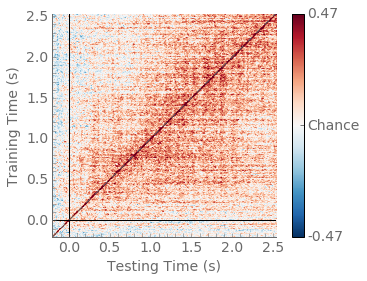

ad120287
['AllVis_Train_WM', 'Seen_Test_WMx']


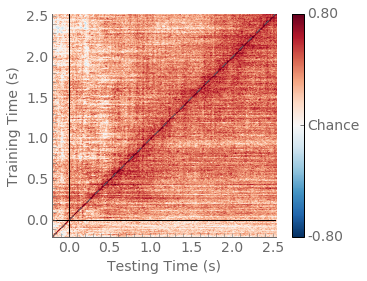

ar140056
['AllVis_Train_WM', 'Seen_Test_WMx']


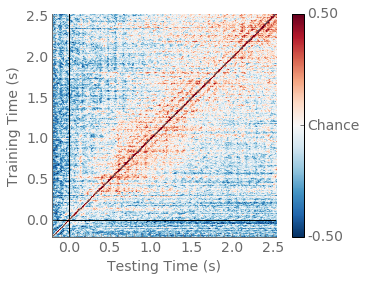

cc140058
['AllVis_Train_WM', 'Seen_Test_WMx']


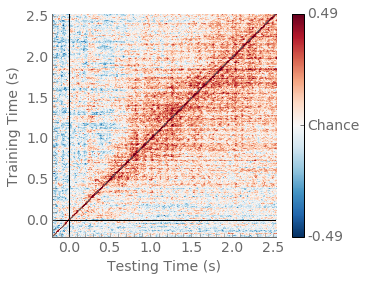

eg140204
['AllVis_Train_WM', 'Seen_Test_WMx']


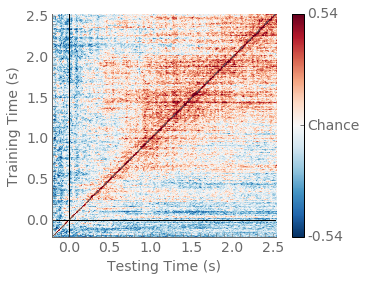

el130086
['AllVis_Train_WM', 'Seen_Test_WMx']


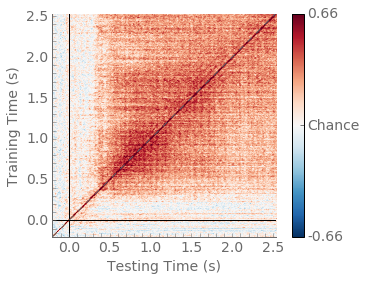

lm130479
['AllVis_Train_WM', 'Seen_Test_WMx']


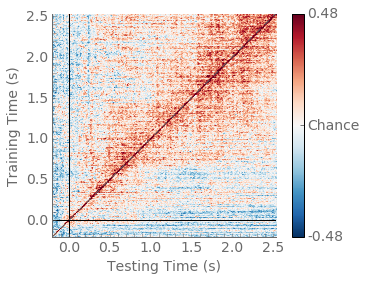

ma130185
['AllVis_Train_WM', 'Seen_Test_WMx']


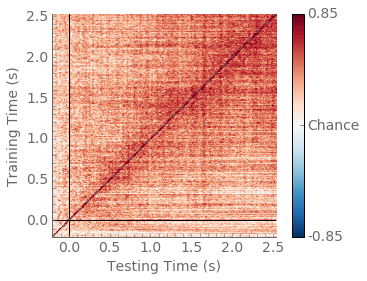

ro130031
['AllVis_Train_WM', 'Seen_Test_WMx']


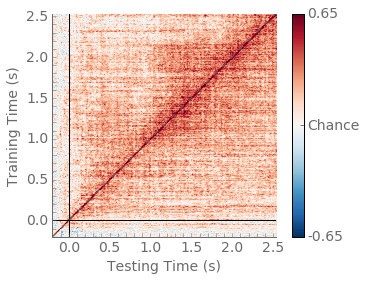

sa130042
['AllVis_Train_WM', 'Seen_Test_WMx']


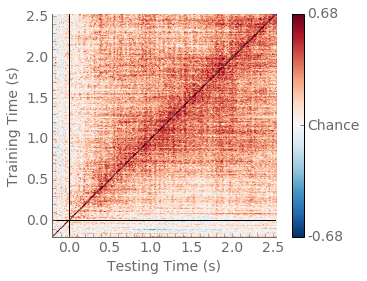

sb120316
['AllVis_Train_WM', 'Seen_Test_WMx']


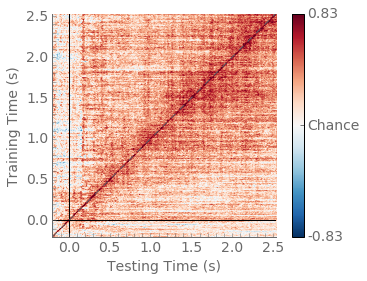

th130177
['AllVis_Train_WM', 'Seen_Test_WMx']


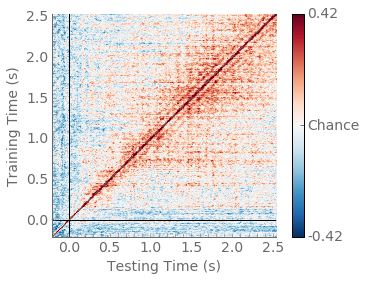

ws140212
['AllVis_Train_WM', 'Seen_Test_WMx']


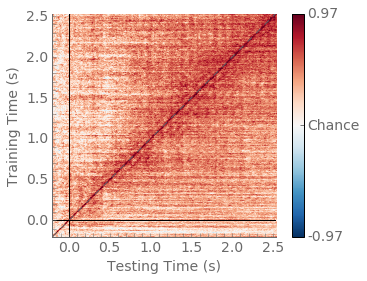

In [14]:
####################Plot original GAT####################
for c, cond in enumerate(ListCondition):
    for s, sub in enumerate(ListSubject):
        print(sub)
        print(cond)
        pretty_gat(all_scores[c, s, :, :], times = time, chance = chance, ax = None, sig = None, cmap = 'RdBu_r',
             clim = None, colorbar = True, xlabel = 'Testing Time (s)', 
             ylabel = 'Training Time (s)', sfreq = 250, diagonal = 'dimgray', test_times = None, smoothWindow=0)
        plt.show()

['AllVis_Train_WM', 'Seen_Test_WMx']


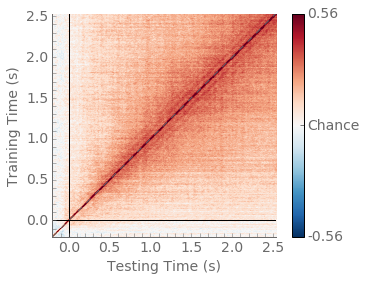

In [15]:
####################Plot original GAT####################
for c, cond in enumerate(ListCondition):
    print(cond)
    pretty_gat(group_scores[c, :, :], times = time, chance = chance, ax = None, sig = None, cmap = 'RdBu_r',
             clim = None, colorbar = True, xlabel = 'Testing Time (s)', 
             ylabel = 'Training Time (s)', sfreq = 250, diagonal = 'dimgray', test_times = None, smoothWindow=0)
    plt.show()

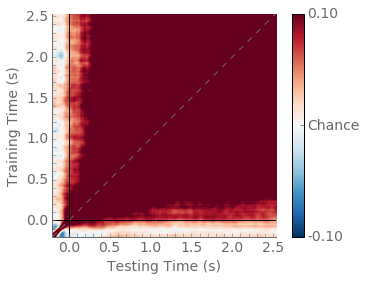

In [16]:
##### Plot GAT with uncorrected p values####################
for c, cond in enumerate(ListCondition):
    classLines = [None, None, toi, toi]
    pretty_gat(group_scores[c, :, :], times = time, chance = chance, ax = None, sig = None, cmap = 'RdBu_r',
             clim = [-0.1, 0.1], colorbar = True, xlabel = 'Testing Time (s)', 
             ylabel = 'Training Time (s)', sfreq = 250, diagonal = 'dimgray', test_times = None, smoothWindow=8)
    fname = groupResult_path + '/' + cond[0] + '_' + cond[1] + '-uncorrectedGAT.tif'
    plt.savefig(fname, format = 'tif', dpi = 300, bbox_inches = 'tight')
    plt.show()

['AllVis_Train_WM', 'Seen_Test_WMx']


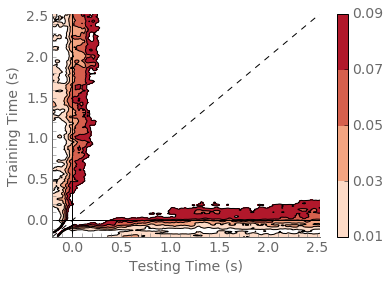

In [17]:
##### Plot GAT with uncorrected p values####################
for c, cond in enumerate(ListCondition):
    classLines = [None, None, toi, toi]
    print(cond)
    pretty_gat(group_scores[c, :, :], times = time, chance = chance, ax = None, sig = None, cmap = 'RdBu_r',
             clim = [-0.1, 0.1], colorbar = None, xlabel = 'Testing Time (s)', 
             ylabel = 'Training Time (s)', sfreq = 250, diagonal = 'k', test_times = None, smoothWindow=8, 
              contourPlot = True, steps = [0.01, 0.03, 0.05, 0.07, 0.09])
    fname = groupResult_path + '/' + cond[0] + '_' + cond[1] + '-uncorrectedGAT_contour.tif'
    plt.savefig(fname, format = 'tif', dpi = 300, bbox_inches = 'tight')
    plt.show()

['AllVis_Train_WM', 'Seen_Test_WMx']
[-0.2   -0.196 -0.192 -0.188 -0.184 -0.18  -0.176 -0.172 -0.168 -0.164
 -0.16  -0.156 -0.152 -0.148 -0.144 -0.14  -0.136 -0.132 -0.128 -0.124
 -0.12  -0.116 -0.112 -0.108 -0.104 -0.1   -0.096 -0.092 -0.088 -0.084
 -0.08  -0.076 -0.072 -0.068 -0.064 -0.06  -0.056 -0.052 -0.048 -0.044
 -0.04  -0.036 -0.032 -0.028 -0.024 -0.02  -0.016 -0.012 -0.008 -0.004  0.
  0.004  0.008  0.012  0.016  0.02   0.024  0.028  0.032  0.036  0.04
  0.044  0.048  0.052  0.056  0.06   0.064  0.068  0.072  0.076  0.08
  0.084  0.088  0.092  0.096  0.1    0.104  0.108  0.112  0.116  0.12
  0.124  0.128  0.132  0.136  0.14   0.144  0.148  0.152  0.156  0.16
  0.164  0.168  0.172  0.176  0.18   0.184  0.188  0.192  0.196  0.2    0.204
  0.208  0.212  0.216  0.22   0.224  0.228  0.232  0.236  0.24   0.244
  0.248  0.252  0.256  0.26   0.264  0.268  0.272  0.276  0.28   0.284
  0.288  0.292  0.296  0.3    0.304  0.308  0.312  0.316  0.32   0.324
  0.328  0.332  0.336  0.34   0.3

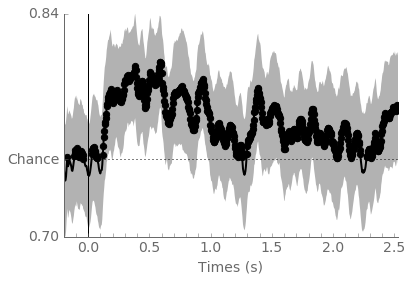

In [23]:
####################Plot decoding with uncorrected p values####################
#colors = ['dodgerblue', 'darkturquoise', 'darkred', 'crimson']
colors = [(0.0, 0.4470588235294118, 0.6980392156862745),
                 (0.0, 0.6196078431372549, 0.45098039215686275),
                 (0.8352941176470589, 0.3686274509803922, 0.0),
                 (0.8, 0.4745098039215686, 0.6549019607843137),
                 (0.9411764705882353, 0.8941176470588236, 0.25882352941176473),
                 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

for c, cond in enumerate(ListCondition):
        print (cond)
        print(time[np.where(p_values_diagonal[c, :] < .05)])
        pretty_decod(all_diagonals[c, :, :], times=time, chance=0.75, ax=None, sig=p_values_diagonal[c, :], width=20.,
                 color='k', fill=False, xlabel='Times (s)', sfreq=250, alpha=.02, scat=True, line=False, smoothWindow=8, lim = None, thickness = 2, thicknessScat=40, schrift = 14)
        fname = groupResult_path + '/' + cond[0] + '_' + cond[1] + '-uncorrectedDiag_smooth.tif'
        plt.savefig(fname, format = 'tif', dpi = 300, bbox_inches = 'tight')
        
        plt.show()

Time is 0.332 and mean is 0.0910317104711 and sem is 0.0315423509858 and sig is 0.0231997309355
Time is 0.46 and mean is 0.141609268515 and sem is 0.0326777050153 and sig is 0.0320150742165
Time is 0.476 and mean is 0.128831596586 and sem is 0.0356844745908 and sig is 0.0231997309355
Time is 0.492 and mean is 0.143229914859 and sem is 0.0401593770092 and sig is 0.0115649012487
Time is 0.6 and mean is 0.0983003671241 and sem is 0.0415019557755 and sig is 0.0373677491529
Time is 0.604 and mean is 0.151609664291 and sem is 0.0472928001371 and sig is 0.00438731653005
Time is 0.616 and mean is 0.146817756625 and sem is 0.048889135706 and sig is 0.013853924679
Time is 0.728 and mean is 0.126683514265 and sem is 0.0498959995137 and sig is 0.0434300407581
Time is 0.744 and mean is 0.149060443904 and sem is 0.0509355717165 and sig is 0.0196216380752
Time is 0.832 and mean is 0.140867372695 and sem is 0.0513865306221 and sig is 0.0231997309355
Time is 0.848 and mean is 0.113057501575 and sem is 

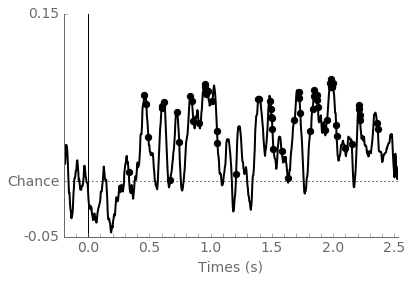

In [18]:
####################Plot decoding with corrected p values####################
#colors = ['dodgerblue', 'darkturquoise', 'darkred', 'crimson']
colors = [(0.0, 0.4470588235294118, 0.6980392156862745),
                 (0.0, 0.6196078431372549, 0.45098039215686275),
                 (0.8352941176470589, 0.3686274509803922, 0.0),
                 (0.8, 0.4745098039215686, 0.6549019607843137),
                 (0.9411764705882353, 0.8941176470588236, 0.25882352941176473),
                 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

for c, cond in enumerate(ListCondition):
        times_sig = np.intersect1d(time[p_values_diagonal[c, :] < .05], time[group_diagonal[c, :] > 0])
        sem_sig = np.intersect1d(sem_group_diagonal[c, :][p_values_diagonal[c, :] < .05], sem_group_diagonal[c, :][group_diagonal[c, :] > 0])
        
        dummy1 = group_diagonal[c, :][p_values_diagonal[c, :] < .05]
        scores_sig = dummy1[dummy1 > 0]
        
        dummy2 = p_values_diagonal[c, :][group_diagonal[c, :] > 0]
        sig_sig = dummy2[dummy2 < .05]

  
        for l, length in enumerate(times_sig):
            print("Time is {} and mean is {} and sem is {} and sig is {}".format(times_sig[l], scores_sig[l], sem_sig[l], sig_sig[l]))
            #print("Sig is {}".format(sig_sig[l]))
            #print(str(times_sig[l]) + ':' + str(scores_sig[l]) + '+/-' + str(sem_sig[l]))
            #print(times_sig[l])
            #print(':')
            #print(scores_sig[l])
        
        #print(time[np.where(p_values_diagonal_fdr[c, :] < .05) and group_diagonal > .5])
        pretty_decod(group_diagonal[c, :], times=time, chance=0, ax=None, sig=p_values_diagonal[c, :], width=20.,
                 color='k', fill=False, xlabel='Times (s)', sfreq=250, alpha=.02, scat=True, line=False, smoothWindow=8, lim = [-0.05, 0.15], thickness = 2, thicknessScat=40, schrift = 14)
        fname = groupResult_path + '/' + cond[0] + '_' + cond[1] + '-correctedDiag_smooth.tif'
        plt.savefig(fname, format = 'tif', dpi = 300, bbox_inches = 'tight')
        
        plt.show()

['AllVis_Train_WM', 'AllVis_Test_WM']
(-0.015735187788774425, 1)
0.0285525797082
(0.019442459917877939, 1)
0.0249062643986
(0.038252617161009514, 1)
0.0144653810445
(0.037129720235493199, 1)
0.0247847582425
0.350351706126
0.276246668001
0.00795322205085
0.110665041497


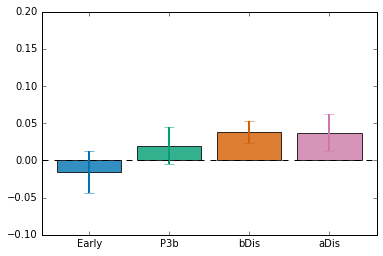

In [19]:
####################Plot diagonal in time bins####################
#Load important libraries
import matplotlib.pyplot as plt

#Define important variables
n_bins = len(timeBins)
font = {'fontname': 'Arial', 'fontsize': 14}

colors_blind = [(0.0, 0.4470588235294118, 0.6980392156862745),
                 (0.0, 0.6196078431372549, 0.45098039215686275),
                 (0.8352941176470589, 0.3686274509803922, 0.0),
                 (0.8, 0.4745098039215686, 0.6549019607843137),
                 (0.9411764705882353, 0.8941176470588236, 0.25882352941176473),
                 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
               (0.0, 0.4470588235294118, 0.6980392156862745),
               (0.0, 0.6196078431372549, 0.45098039215686275),
                (0.8352941176470589, 0.3686274509803922, 0.0),]

xLabels = ['Early', 'P3b', 'bDis', 'aDis']

x = np.arange(n_bins)
index = np.arange(n_bins)

for c, cond in enumerate(ListCondition):
    ax = plt.gca()
    print(cond)
        
    ax.bar(x, np.mean(group_diagonal_AVG[c, :, :], 1), alpha = 0.8, color = colors_blind)
        
    print(np.mean(group_diagonal_AVG[c, 0, :]), 1)
    print(sem_group_diagonal_AVG[c, 0])
        
    print(np.mean(group_diagonal_AVG[c, 1, :]), 1)
    print(sem_group_diagonal_AVG[c, 1])
    
    print(np.mean(group_diagonal_AVG[c, 2, :]), 1)
    print(sem_group_diagonal_AVG[c, 2])
    
    print(np.mean(group_diagonal_AVG[c, 3, :]), 1)
    print(sem_group_diagonal_AVG[c, 3])
        
    print(p_values_group_diagonal_AVG[c, 0])
    print(p_values_group_diagonal_AVG[c, 1])
    print(p_values_group_diagonal_AVG[c, 2])
    print(p_values_group_diagonal_AVG[c, 3])
        
    for pos, y, err, color in zip(x, np.mean(group_diagonal_AVG[c, :, :], 1), sem_group_diagonal_AVG[c, :], colors_blind):
        ax.errorbar(pos + 0.4, y, err, lw = 2, capsize = 5, color = color)

    #Plot chance level
    plt.axhline(0.0, color = 'k', ls = '--')

    #Take care of axes
    ax.margins(0.05) #spacing at the 
    ax.set_xticks(index + 0.4)
    ax.set_xticklabels(xLabels)
    ax.set_ylim([-0.1, 0.2])
    plt.show()